# Exploratory Data Analysis - Predictive Delivery Optimizer

This notebook contains exploratory data analysis visualizations for the delivery delay prediction project.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

# Define paths
project_root = Path().absolute().parent
data_dir = project_root / "data"
processed_dir = project_root / "processed"

# Load data
merged_path = processed_dir / "merged.csv"
if merged_path.exists():
    df = pd.read_csv(merged_path)
else:
    # Fallback: load and merge original data
    orders_df = pd.read_csv(data_dir / "orders.csv")
    delivery_df = pd.read_csv(data_dir / "delivery_performance.csv")
    routes_df = pd.read_csv(data_dir / "routes_distance.csv")
    
    df = pd.merge(orders_df, delivery_df, on="Order_ID", how="inner")
    df = pd.merge(df, routes_df, on="Order_ID", how="inner")
    
    # Drop leakage columns
    leakage_columns = ["Route", "Origin", "Destination", "Customer_Segment", 
                       "Order_Date", "Special_Handling", "Delivery_Status", "Quality_Issue"]
    df = df.drop(columns=[col for col in leakage_columns if col in df.columns])
    
    # Create targets
    df["delay_days"] = df["Actual_Delivery_Days"] - df["Promised_Delivery_Days"]
    df["is_delayed"] = (df["delay_days"] > 0).astype(int)

print(f"Data shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Data shape: (150, 16)

First few rows:


,Order_ID,Priority,Product_Category,Order_Value_INR,Carrier,Promised_Delivery_Days,Actual_Delivery_Days,Customer_Rating,Delivery_Cost_INR,Distance_KM,Fuel_Consumption_L,Toll_Charges_INR,Traffic_Delay_Minutes,Weather_Impact,delay_days,is_delayed
0,ORD000001,Express,Industrial,238.73,SpeedyLogistics,1,2,3,387.86,152.59,23.02,122.08,21,NaN,1,1
1,ORD000002,Express,Industrial,17.01,SpeedyLogistics,2,3,1,430.19,362.05,43.98,289.64,33,NaN,1,1
2,ORD000003,Economy,Industrial,3024.95,SpeedyLogistics,10,15,3,1039.19,519.74,65.75,415.79,2,NaN,5,1
3,ORD000004,Economy,Fashion,56.74,QuickShip,5,5,5,599.01,540.87,61.85,432.70,112,NaN,0,0
4,ORD000005,Standard,Fashion,19148.65,SpeedyLogistics,4,5,3,537.90,1251.56,147.54,1001.25,10,NaN,1,1


## 1. Distribution of delay_days


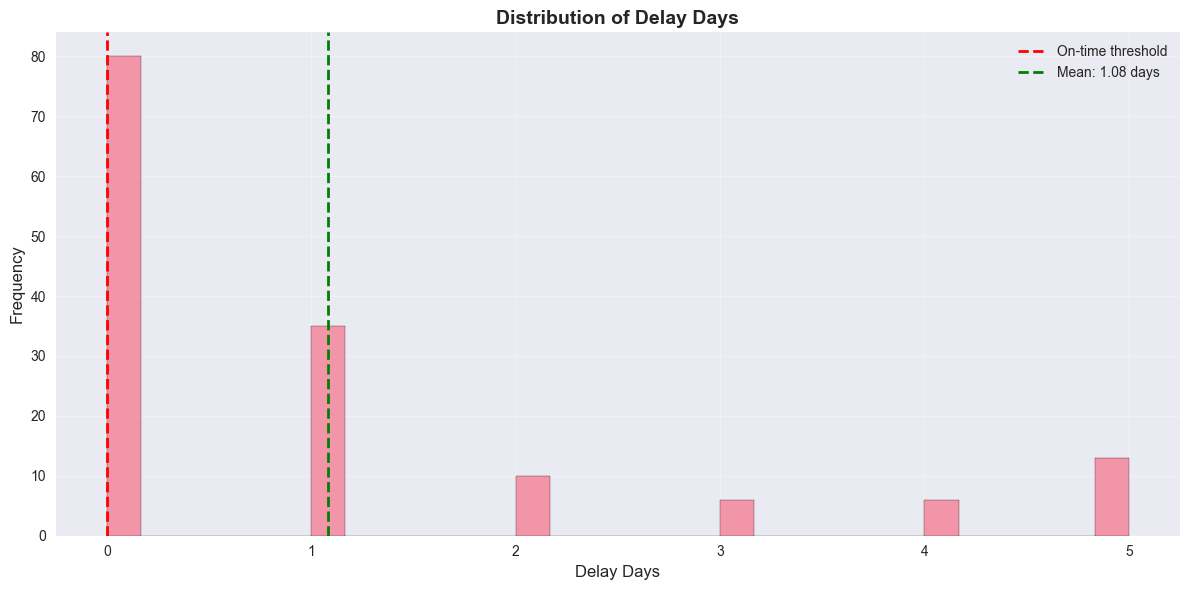

Mean delay: 1.08 days
Median delay: 0.00 days
Std deviation: 1.59 days


In [2]:
plt.figure(figsize=(12, 6))
plt.hist(df["delay_days"], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Delay Days", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Delay Days", fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='On-time threshold')
plt.axvline(x=df["delay_days"].mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {df["delay_days"].mean():.2f} days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean delay: {df['delay_days'].mean():.2f} days")
print(f"Median delay: {df['delay_days'].median():.2f} days")
print(f"Std deviation: {df['delay_days'].std():.2f} days")


## 2. Correlation Heatmap between Numeric Features


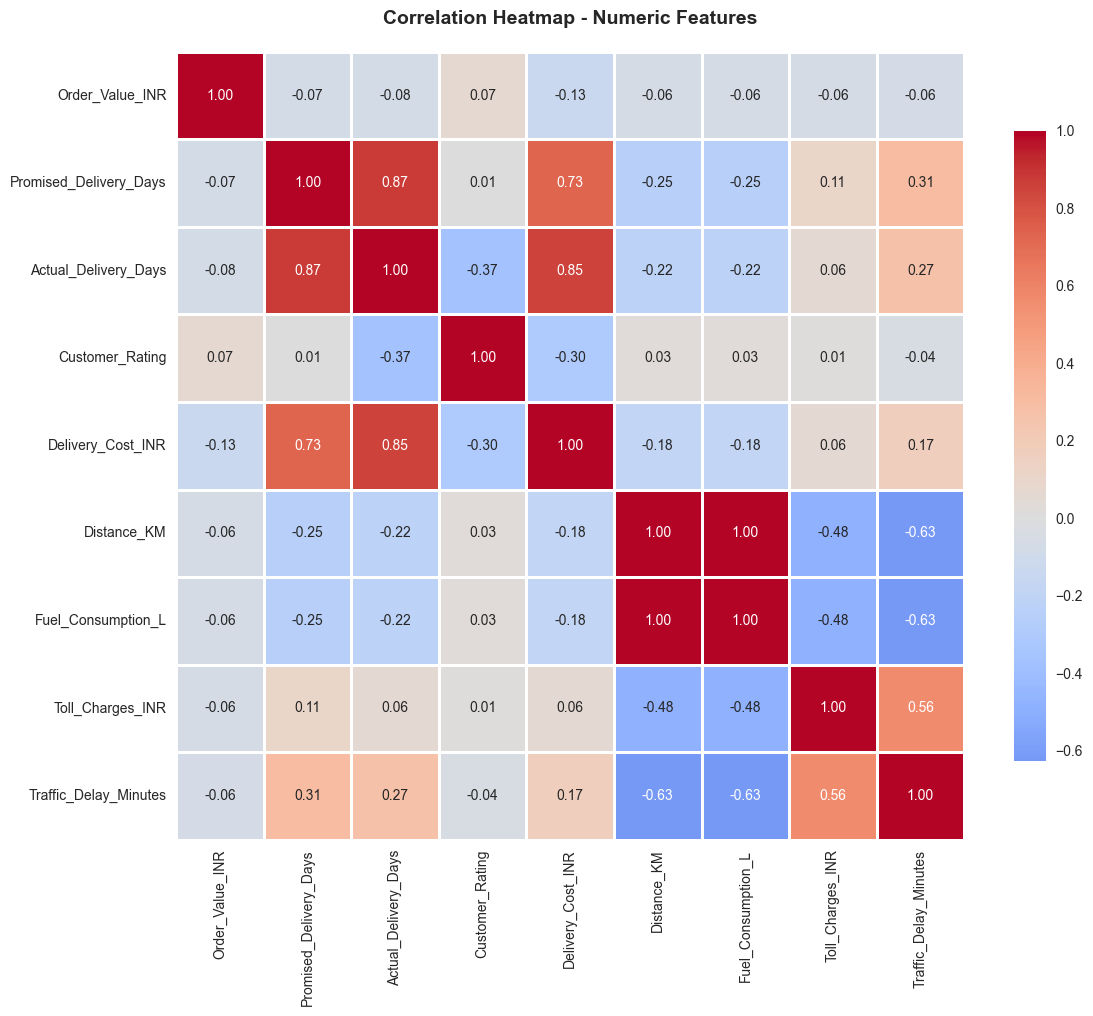

In [3]:
# Select numeric features (excluding targets and Order_ID)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ["delay_days", "is_delayed", "Order_ID"]]

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap - Numeric Features", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## 3. Delay Rate by Carrier


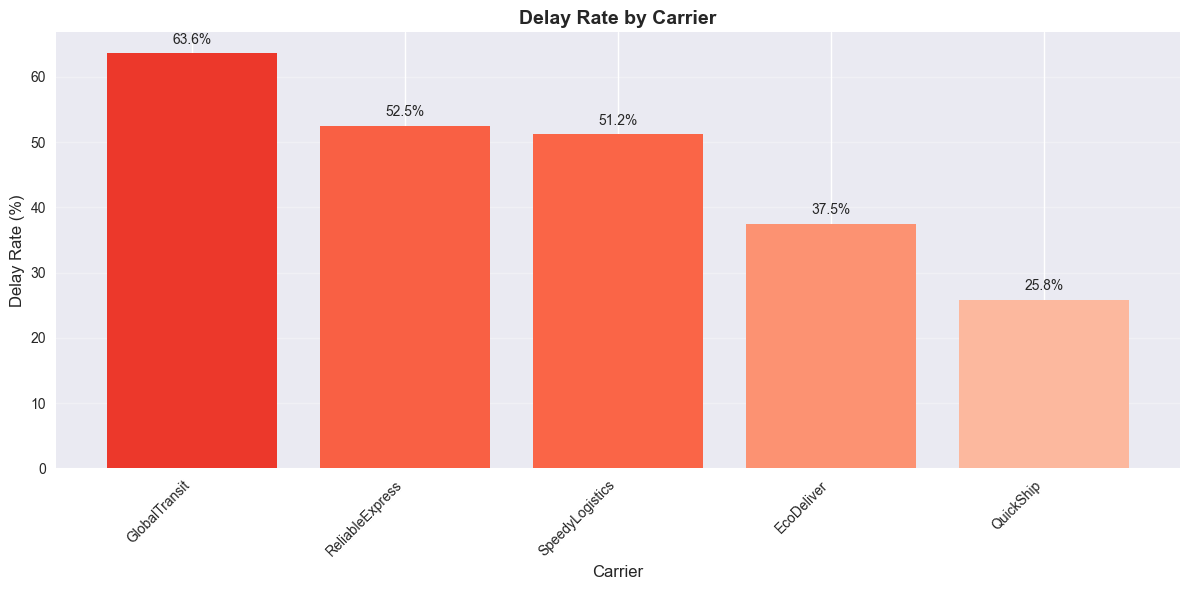


Carrier Delay Statistics:
           Carrier  Delay_Rate  Avg_Delay_Days
1    GlobalTransit   63.636364        1.500000
3  ReliableExpress   52.500000        1.225000
4  SpeedyLogistics   51.219512        1.243902
0       EcoDeliver   37.500000        0.562500
2        QuickShip   25.806452        0.645161


In [4]:
carrier_delays = df.groupby("Carrier").agg({
    "is_delayed": "mean",
    "delay_days": "mean"
}).reset_index()
carrier_delays.columns = ["Carrier", "Delay_Rate", "Avg_Delay_Days"]
carrier_delays["Delay_Rate"] = carrier_delays["Delay_Rate"] * 100
carrier_delays = carrier_delays.sort_values("Delay_Rate", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(carrier_delays["Carrier"], carrier_delays["Delay_Rate"], 
               color=plt.cm.Reds(carrier_delays["Delay_Rate"] / 100))
plt.xlabel("Carrier", fontsize=12)
plt.ylabel("Delay Rate (%)", fontsize=12)
plt.title("Delay Rate by Carrier", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars, carrier_delays["Delay_Rate"])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nCarrier Delay Statistics:")
print(carrier_delays)


## 4. Delay vs Weather Impact


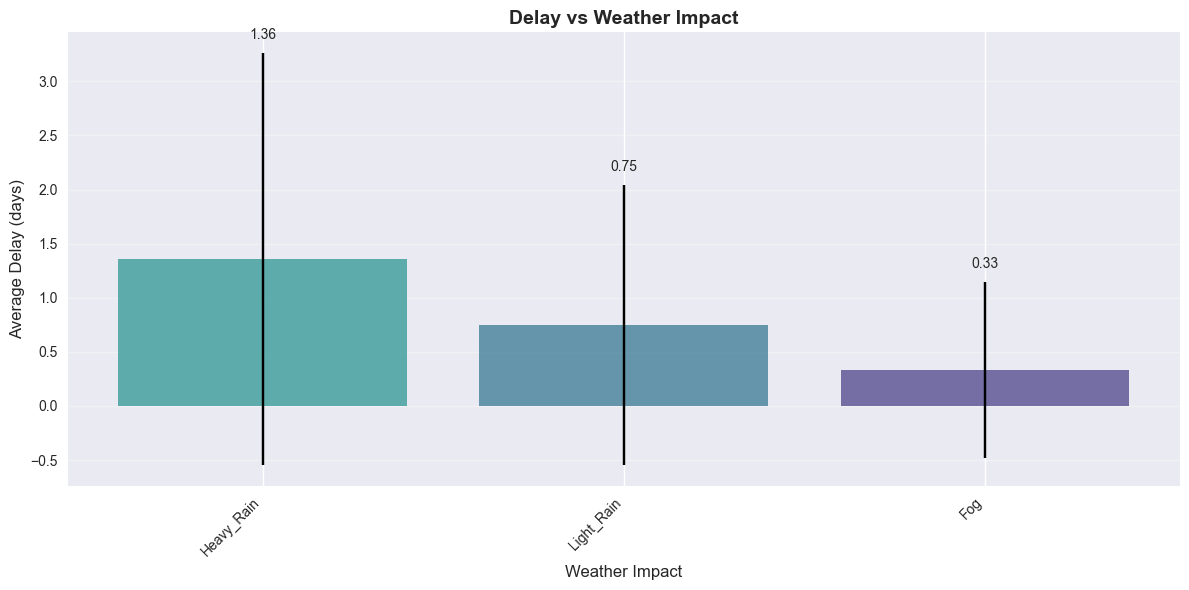


Weather Impact Analysis:
  Weather_Impact  Avg_Delay  Std_Delay  Delay_Rate  Count
1     Heavy_Rain   1.357143   1.905746   50.000000     14
2     Light_Rain   0.750000   1.293798   37.500000     24
0            Fog   0.333333   0.816497   16.666667      6


In [5]:
weather_analysis = df.groupby("Weather_Impact").agg({
    "delay_days": ["mean", "std"],
    "is_delayed": "mean",
    "Order_ID": "count"
}).reset_index()
weather_analysis.columns = ["Weather_Impact", "Avg_Delay", "Std_Delay", "Delay_Rate", "Count"]
weather_analysis["Delay_Rate"] = weather_analysis["Delay_Rate"] * 100
weather_analysis = weather_analysis.sort_values("Avg_Delay", ascending=False)

plt.figure(figsize=(12, 6))
x_pos = np.arange(len(weather_analysis))
bars = plt.bar(x_pos, weather_analysis["Avg_Delay"], 
               yerr=weather_analysis["Std_Delay"],
               capsize=5, alpha=0.7, color=plt.cm.viridis(weather_analysis["Delay_Rate"] / 100))

plt.xlabel("Weather Impact", fontsize=12)
plt.ylabel("Average Delay (days)", fontsize=12)
plt.title("Delay vs Weather Impact", fontsize=14, fontweight='bold')
plt.xticks(x_pos, weather_analysis["Weather_Impact"], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, avg_delay) in enumerate(zip(bars, weather_analysis["Avg_Delay"])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + weather_analysis.iloc[i]["Std_Delay"] + 0.1,
             f'{avg_delay:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nWeather Impact Analysis:")
print(weather_analysis)


## 5. Priority Level vs Delay Days


C:\Users\NEYAZ AHMED\AppData\Local\Temp\ipykernel_27844\4157886829.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(box_data, labels=[p for p in priority_analysis["Priority"] if p in df["Priority"].values],


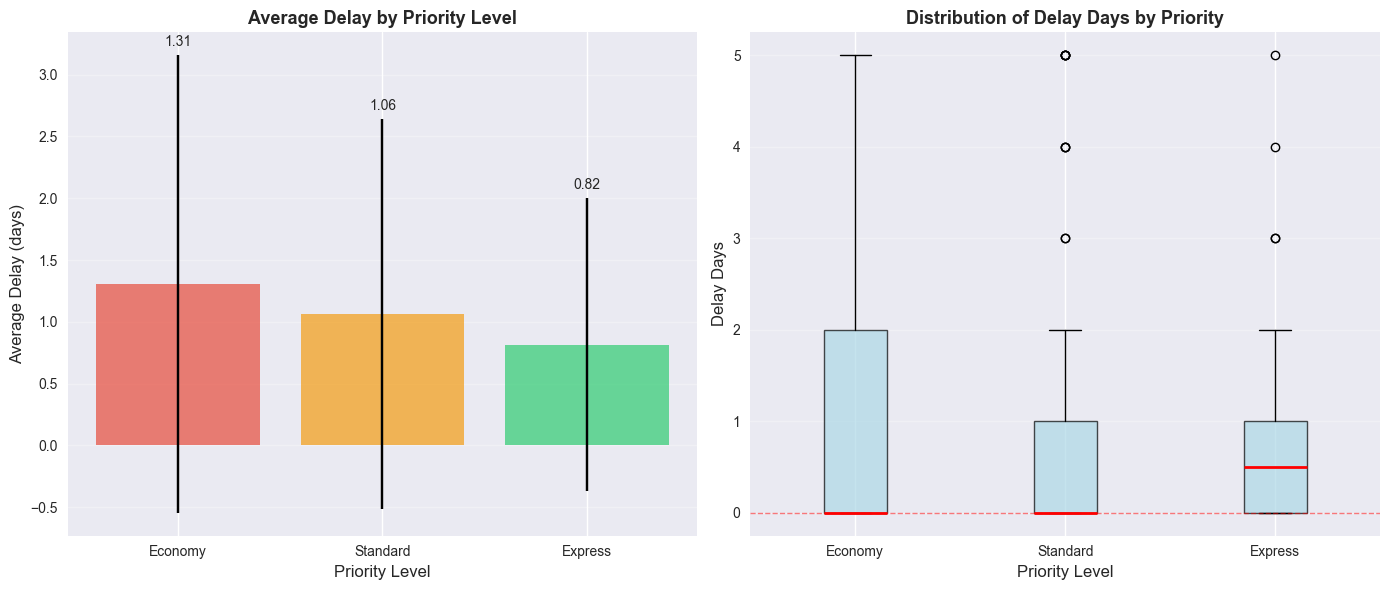


Priority Level Analysis:
   Priority  Mean_Delay  Median_Delay  Std_Delay  Delay_Rate
0   Economy    1.306122           0.0   1.850721   44.897959
2  Standard    1.063492           0.0   1.574730   46.031746
1   Express    0.815789           0.5   1.182194   50.000000


In [6]:
priority_analysis = df.groupby("Priority").agg({
    "delay_days": ["mean", "median", "std"],
    "is_delayed": "mean"
}).reset_index()
priority_analysis.columns = ["Priority", "Mean_Delay", "Median_Delay", "Std_Delay", "Delay_Rate"]
priority_analysis["Delay_Rate"] = priority_analysis["Delay_Rate"] * 100

# Order by priority level
priority_order = ["Economy", "Standard", "Express", "Unknown"]
priority_analysis["Priority"] = pd.Categorical(priority_analysis["Priority"], categories=priority_order, ordered=True)
priority_analysis = priority_analysis.sort_values("Priority")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for mean delay
x_pos = np.arange(len(priority_analysis))
bars1 = ax1.bar(x_pos, priority_analysis["Mean_Delay"], 
                yerr=priority_analysis["Std_Delay"],
                capsize=5, alpha=0.7, color=['#e74c3c', '#f39c12', '#2ecc71', '#95a5a6'])
ax1.set_xlabel("Priority Level", fontsize=12)
ax1.set_ylabel("Average Delay (days)", fontsize=12)
ax1.set_title("Average Delay by Priority Level", fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(priority_analysis["Priority"], rotation=0)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, mean_delay) in enumerate(zip(bars1, priority_analysis["Mean_Delay"])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + priority_analysis.iloc[i]["Std_Delay"] + 0.05,
             f'{mean_delay:.2f}', ha='center', va='bottom', fontsize=10)

# Box plot for distribution
box_data = [df[df["Priority"] == p]["delay_days"].values for p in priority_analysis["Priority"] if p in df["Priority"].values]
ax2.boxplot(box_data, labels=[p for p in priority_analysis["Priority"] if p in df["Priority"].values],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_xlabel("Priority Level", fontsize=12)
ax2.set_ylabel("Delay Days", fontsize=12)
ax2.set_title("Distribution of Delay Days by Priority", fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nPriority Level Analysis:")
print(priority_analysis)
